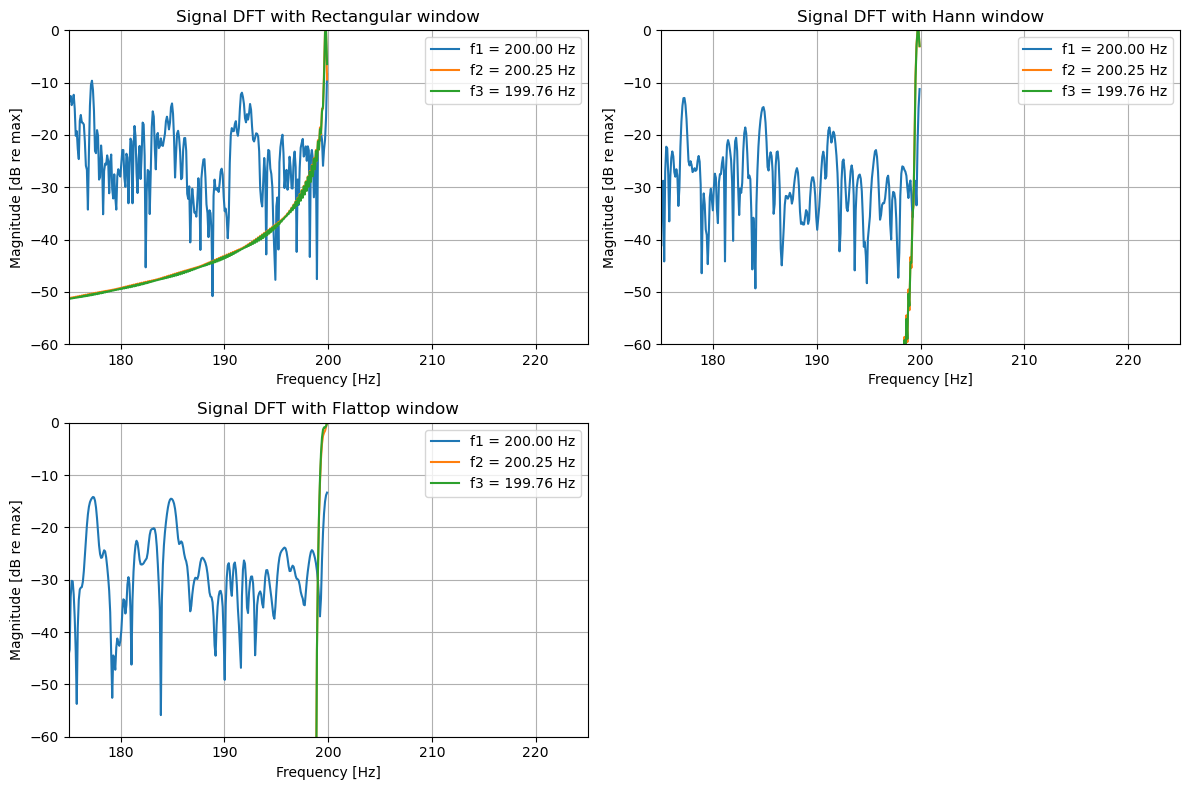

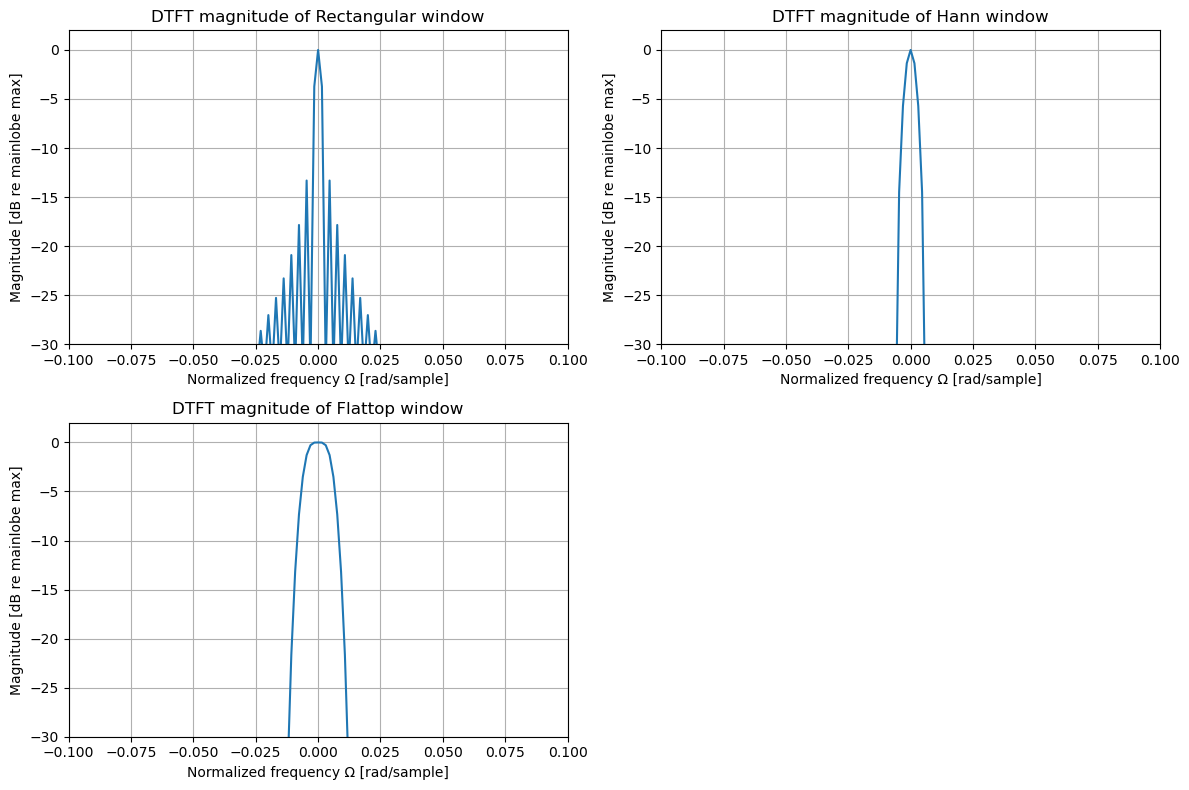

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# PARAMETERS
# ==========================
fs = 400      # sampling frequency [Hz]
N  = 2000         # number of samples

f1 = 200
f2 = 200.25
f3 = 199.76

A = 4.0          # amplitude -> |x[k]|_max = A for each sinusoid
n_fft = 4096     # FFT size for smooth spectra

# ==========================
# SIGNAL GENERATION (SEPARATE)
# ==========================
k = np.arange(N)

x1 = A * np.sin(2 * np.pi * f1 * k / fs)
x2 = A * np.sin(2 * np.pi * f2 * k / fs)
x3 = A * np.sin(2 * np.pi * f3 * k / fs)

signals = {
    f"f1 = {f1:.2f} Hz": x1,
    f"f2 = {f2:.2f} Hz": x2,
    f"f3 = {f3:.2f} Hz": x3,
}

# ==========================
# CUSTOM FLATTOP WINDOW (pure NumPy, no SciPy)
# ==========================
def flattop_window(N: int) -> np.ndarray:
    """
    Standard 5-term flat-top window (Harris coefficients).
    Good for amplitude-accurate FFT measurement.
    """
    n = np.arange(N)
    a0 = 1.0
    a1 = 1.93
    a2 = 1.29
    a3 = 0.388
    a4 = 0.028
    w = (
        a0
        - a1 * np.cos(2 * np.pi * n / (N - 1))
        + a2 * np.cos(4 * np.pi * n / (N - 1))
        - a3 * np.cos(6 * np.pi * n / (N - 1))
        + a4 * np.cos(8 * np.pi * n / (N - 1))
    )
    return w

# ==========================
# WINDOWS
# ==========================
windows = {
    "Rectangular": np.ones(N),
    "Hann":        np.hanning(N),
    "Flattop":     flattop_window(N),
}

# Frequency axis for DFT (0 .. fs/2)
freq = np.linspace(0, fs, n_fft, endpoint=False)
half = n_fft // 2
freq_half = freq[:half]

# ==========================
# HELPER: MAGNITUDE TO dB
# ==========================
def mag2db(x, min_db=-120):
    mag = np.abs(x)
    mag = np.maximum(mag, 1e-12)  # avoid log(0)
    db = 20 * np.log10(mag)
    db = np.maximum(db, min_db)
    return db

# ==========================
# 1. NORMALIZED DFT SPECTRA OF EACH SIGNAL
#    (each signal treated separately)
# ==========================
plt.figure(figsize=(12, 8))

for i, (wname, w) in enumerate(windows.items(), start=1):
    plt.subplot(2, 2, i)

    for sname, x in signals.items():
        xw = x * w

        X = np.fft.fft(xw, n=n_fft)
        X = X[:half]

        # Normalize spectrum of THIS signal+window to its own max
        X_norm = X / np.max(np.abs(X))
        X_db = mag2db(X_norm)

        plt.plot(freq_half, X_db, label=sname)

    plt.title(f"Signal DFT with {wname} window")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude [dB re max]")
    #plt.ylim([-120, 5])
    plt.xlim(175, 225)   # zawęzić do okolic 200 Hz
    plt.ylim(-60, 0)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# ==========================
# 2. WINDOW DTFT SPECTRA (NORMALIZED TO MAINLOBE MAX)
# ==========================
plt.figure(figsize=(12, 8))

for i, (wname, w) in enumerate(windows.items(), start=1):
    W = np.fft.fft(w, n=n_fft)
    W = np.fft.fftshift(W)  # center zero frequency
    W_norm = W / np.max(np.abs(W))  # normalize to mainlobe max
    W_db = mag2db(W_norm)

    # Normalized frequency axis in rad/sample (−π..π)
    omega = np.linspace(-np.pi, np.pi, n_fft, endpoint=False)

    plt.subplot(2, 2, i)
    plt.plot(omega, W_db)
    plt.title(f"DTFT magnitude of {wname} window")
    plt.xlabel("Normalized frequency Ω [rad/sample]")
    plt.ylabel("Magnitude [dB re mainlobe max]")
    plt.ylim([-120, 5])
    plt.grid(True)
    # for zoom (dB)
    plt.xlim(-0.1, 0.1)
    plt.ylim(-30, 2)

plt.tight_layout()
plt.show()


In [6]:
print("x max:", np.max(x))
print("x min:", np.min(x))
print("x rms:", np.sqrt(np.mean(x**2)))

x max: 8.604228440844963e-12
x min: -9.690026558928366e-12
x rms: 2.1937473213379956e-12
